# Team Wiski

- Murielle Mardenli - 2155882 - murielle.mardenli@polymtl.ca
- Zarine Amy Ardekani-Djoneidi - 2139186 - zarine-amy.ardekani-djoneidi@polymtl.ca
- Lucas Bouchard - 2143675 - lucas-2.bouchard@polymtl.ca

# 1. Data exploration and preprocessing

## Imports

In [4]:
from warnings import simplefilter
simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import json
from copy import deepcopy
import itertools as iter


from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

Using random seeds for reproducibility:

In [5]:
np.random.seed(0)
torch.manual_seed(197331)

## Data Exploration

In [6]:
training_set = pd.read_csv("./train.csv")
testing_set = pd.read_csv("./test.csv")

train_features = training_set.iloc[:, 1:]
train_labels = pd.read_csv("./labels.csv").iloc[:, 1:]
test_features = testing_set.iloc[:, 1:]
test_ids = testing_set.iloc[:, 0]

train_features.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,Age,Education,Income,BMI_Category,Healthy_Diet,Mental_Health_Risk,Heart_Disease_Risk,Age_Group,Education_Level,Income_Group
0,0,1,1,20.693674,1,0,0,1,1,1,...,11.725312,6.0,8.0,Normal weight,1,0,2,Young,Some College,High Income
1,0,0,1,28.375985,0,0,0,1,0,1,...,7.977719,5.0,8.0,Obese,0,0,0,Young,Some College,High Income
2,1,1,1,24.629353,0,0,0,1,1,1,...,8.161838,5.0,6.0,Normal weight,1,0,2,Young,Some College,Middle Income
3,0,1,1,27.246610,0,0,0,1,1,1,...,5.038298,6.0,7.0,Overweight,1,0,1,Young,Some College,High Income
4,0,1,1,23.671678,0,0,0,1,1,1,...,12.037360,4.0,6.0,Normal weight,1,0,1,Young,High School Graduate,Middle Income


Checking that there are no missing values:

In [7]:
print("NaN values in training set:", train_features.isna().sum().sum())
print("NaN values in testing set:", test_features.isna().sum().sum())
print(f"nbr of missing values in the feature set: {train_features.isnull().sum().sum()}")
print(f"nbr of missing values in the label set: {train_features.isnull().sum().sum()}")

NaN values in training set: 0
NaN values in testing set: 0
nbr of missing values in the feature set: 0
nbr of missing values in the label set: 0


Checking percentage of negative and positive labels:

In [8]:
positive_samples = train_features[train_labels["Diabetes_binary"] == 1]
negative_samples = train_features[train_labels["Diabetes_binary"] == 0]

nbr_samples = len(train_features)
nbr_pos_samples = len(positive_samples)
nbr_neg_samples = len(negative_samples)

print(f"% of samples without Diabetes: {round(nbr_neg_samples*100/nbr_samples, 2)}")
print(f"% of samples with Diabetes   : {round(nbr_pos_samples*100/nbr_samples, 2)}")

% of samples without Diabetes: 86.03
% of samples with Diabetes   : 13.97


In [9]:
train_features.iloc[:, :14].describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth
count,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000
mean,0.428212,0.423664,0.962748,28.367242,0.442866,0.040578,0.094238,0.757081,0.634407,0.811766,0.056178,0.951026,0.084107,2.511831
std,0.494821,0.494140,0.189378,6.284137,0.496726,0.197310,0.292160,0.428848,0.481597,0.390900,0.230266,0.215814,0.277549,1.068240
min,0.000000,0.000000,0.000000,11.665176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,1.000000,24.384518,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000
50%,0.000000,0.000000,1.000000,27.897453,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000
75%,1.000000,1.000000,1.000000,30.742114,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000
max,1.000000,1.000000,1.000000,98.446163,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [10]:
train_features.iloc[:, 14:].describe()

,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Healthy_Diet,Mental_Health_Risk,Heart_Disease_Risk
count,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000,202944.000000
mean,3.193190,4.248751,0.168303,0.440427,8.044885,5.146272,6.147045,0.562988,0.189619,1.429557
std,7.435053,8.731686,0.374136,0.496440,2.900076,0.977706,1.986224,0.496018,0.392000,1.150272
min,-1.678270,-1.882606,0.000000,0.000000,0.399947,1.000000,1.000000,0.000000,0.000000,0.000000
25%,-0.131736,-0.115747,0.000000,0.000000,6.134075,4.000000,5.000000,0.000000,0.000000,1.000000
50%,0.218025,0.348222,0.000000,0.000000,8.161838,5.000000,7.000000,1.000000,0.000000,1.000000
75%,1.965709,3.012428,0.000000,1.000000,10.029736,6.000000,8.000000,1.000000,0.000000,2.000000
max,31.249029,31.858730,1.000000,1.000000,13.541879,6.000000,8.000000,1.000000,1.000000,5.000000


**Observation:** Mental health and physical health should be an integer in range [0, 30]. This is not the case in the data.

In [11]:
train_features.describe(include='object')

,BMI_Category,Age_Group,Education_Level,Income_Group
count,202944,202944,202944,202944
unique,4,1,3,3
top,Overweight,Young,Some College,High Income
freq,75064,202944,141754,106875


In [12]:
test_features.describe(include='object')

,BMI_Category,Age_Group,Education_Level,Income_Group
count,50736,50736,50736,50736
unique,4,1,3,3
top,Overweight,Young,Some College,High Income
freq,18685,50736,35481,26729


**Observation:** We should drop the age group because all values are the same.

Plot range of continuous features:

In [13]:
categorical_features = train_features.select_dtypes(include=['object']).columns
continuous_features = [col for col in train_features.select_dtypes(include=['float64', 'int64']).columns if not set(train_features[col]).issubset({0, 1})]

print("Categorical features:", categorical_features)
print("Continuous features:", continuous_features)

Categorical features: Index(['BMI_Category', 'Age_Group', 'Education_Level', 'Income_Group'], dtype='object')
Continuous features: ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income', 'Heart_Disease_Risk']


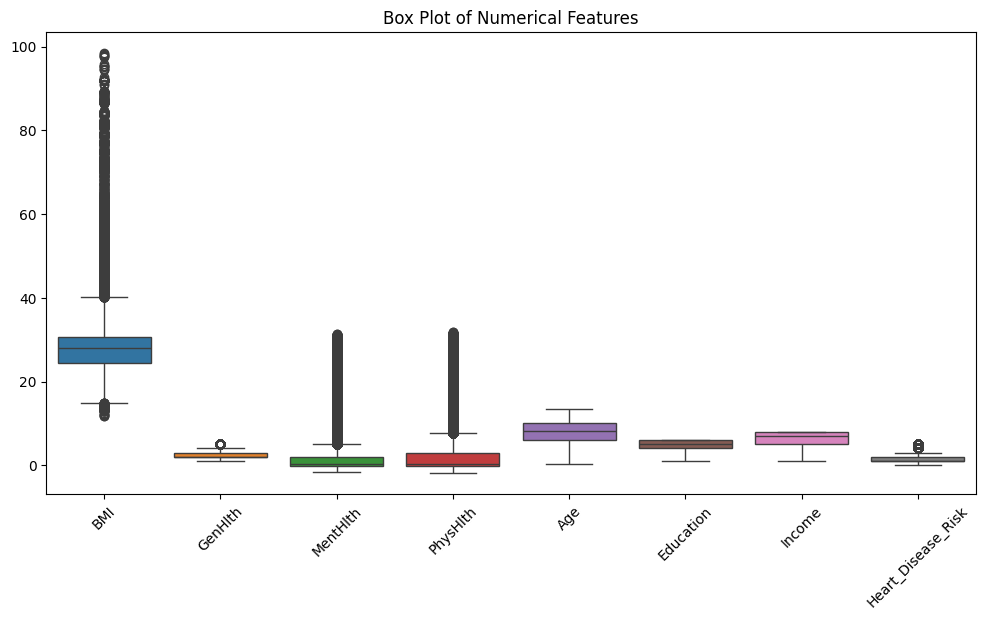

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_features[continuous_features])
plt.xticks(rotation=45)
plt.title("Box Plot of Numerical Features")
plt.show()

**Observation:** The values of the different features are not in the same range, so we should standardize them.

## Preprocessing

Dropping the Age_Group feature:

In [15]:
train_features_processed = train_features.drop("Age_Group", axis=1)
test_features_processed = test_features.drop("Age_Group", axis=1)
categorical_features = train_features_processed.select_dtypes(include=['object']).columns

Standardizing continuous features:

In [16]:
scaler = StandardScaler()
train_features_processed[continuous_features] = scaler.fit_transform(train_features[continuous_features])
test_features_processed[continuous_features] = scaler.transform(test_features[continuous_features])

train_features_processed.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,Sex,Age,Education,Income,BMI_Category,Healthy_Diet,Mental_Health_Risk,Heart_Disease_Risk,Education_Level,Income_Group
0,0,1,1,-1.221104,1,0,0,1,1,1,...,1,1.269082,0.873198,0.932905,Normal weight,1,0,0.495922,Some College,High Income
1,0,0,1,0.001391,0,0,0,1,0,1,...,1,-0.023160,-0.149608,0.932905,Obese,0,0,-1.242802,Some College,High Income
2,1,1,1,-0.594815,0,0,0,1,1,1,...,1,0.040328,-0.149608,-0.074033,Normal weight,1,0,0.495922,Some College,Middle Income
3,0,1,1,-0.178328,0,0,0,1,1,1,...,1,-1.036729,0.873198,0.429436,Overweight,1,0,-0.373440,Some College,High Income
4,0,1,1,-0.747211,0,0,0,1,1,1,...,0,1.376683,-1.172413,-0.074033,Normal weight,1,0,-0.373440,High School Graduate,Middle Income


## Separating validation set

We will hold out 20% of the data as a validation set to test our final stacked model.

In [17]:
X_train, X_val, y_train, y_val = train_test_split(train_features_processed, train_labels, shuffle=True, test_size=0.2, random_state=0)
train_data = X_train.join(y_train)

print("Training set size:", len(y_train))
print("Validation set size:", len(y_val))

Training set size: 162355
Validation set size: 40589


# 2. Defining 2 base models

We will stack two base models:
1. A logistic regression that takes as input the initial data and outputs from a bernoulli naive base model
2. A neural network

First, we need to define functions that will allow us to easily create and train the base models, and use them to make predictions.

## Model 1: Bernoulli Naive Bayes X Logistic Regression

### Create feature combinations json files

In [18]:
features_by_type = {
    "all": X_train.columns,
    "categorical": {"BMI_Category", "Education_Level", "Income_Group"},
    "binary": {"HighBP", "HighChol", "CholCheck", "Smoker", "Stroke", "HeartDiseaseorAttack", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump", "AnyHealthcare", "NoDocbcCost", "DiffWalk", "Sex", "Healthy_Diet", "Mental_Health_Risk"},
    "continuous": {"BMI", "MentHlth", "PhysHlth", "Age", "Income", "Education", "Heart_Disease_Risk", "GenHlth"},
}


def artificial_feature_generator(feature_data, pos_samples, neg_samples, nbr_pos_samples, nbr_neg_samples, i = -1, value_combination = {}):
    if i == -1:
        i = len(feature_data)

    i -= 1

    feature, unique_feature_values = list(feature_data.items())[-i]

    results = []
    for j, unique_value in enumerate(unique_feature_values):
        vc = deepcopy(value_combination)
        vc[f"f{len(feature_data)-i}"] = f"{feature}-{unique_value}"
        select_negative_samples = neg_samples[(neg_samples[feature] == unique_value)]
        select_positive_samples = pos_samples[(pos_samples[feature] == unique_value)]

        if i == 0:
            neg_result = len(select_negative_samples)/nbr_neg_samples
            pos_result = len(select_positive_samples)/nbr_pos_samples

            minimum = min(neg_result, pos_result)
            maximum = max(neg_result, pos_result)
            importance = (1 - (minimum + 1e-10) / maximum) if maximum > 0 else 0
            result = {"importance": float(importance), "pos_presence": pos_result, "neg_presence": neg_result}
            result.update(vc)
            results.append(result)
        else:
            results += artificial_feature_generator(feature_data, select_positive_samples, select_negative_samples, nbr_pos_samples, nbr_neg_samples, i, vc)
    return results





def multivariate_binary_feature_analysis(df: pd.DataFrame, c, write = False):
    """Saves the importance of a sate of combination of c features. For example, if the combination feature1 = 0 and feature2 = 2 is present in 20%
    of the positive population and 60% of the negative population, the importance is 1 - (min/max), so 1 - (0.2/0.6) = 0.666667."""
    positive_samples = df[df["Diabetes_binary"] == 1]
    negative_samples = df[df["Diabetes_binary"] == 0]
    nbr_pos_samples = len(positive_samples)
    nbr_neg_samples = len(negative_samples)

    discrete_features = list(features_by_type["binary"]) + list(features_by_type["categorical"])
    results = []

    for feature_combination in iter.combinations(discrete_features, c):
        feature_data = {feature: sorted(df[feature].unique()) for feature in feature_combination}
        results += artificial_feature_generator(feature_data, positive_samples, negative_samples, nbr_pos_samples, nbr_neg_samples)

    if write:
        with open(f"{c}f_dependencies.json", "w+") as f:
            json.dump(results, f)


    return results

In [20]:
WRITE = False
if WRITE:
    multivariate_binary_feature_analysis(train_data, 1, WRITE)
    multivariate_binary_feature_analysis(train_data, 2, WRITE)
    multivariate_binary_feature_analysis(train_data, 3, WRITE)

### Read feature combinations json files

In [21]:
def read_data(filename):
    with open(filename, "r") as f:
        data = json.load(f)
        sorted_data = sorted(data, key=lambda x : x["importance"], reverse = True)
        df = pd.DataFrame(sorted_data)
        return df

f1_dependencies = read_data("1f_dependencies.json")
f2_dependencies = read_data("2f_dependencies.json")
f3_dependencies = read_data("3f_dependencies.json")

### Function to add feature combinations to data

In [22]:
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

def transform_data(df: pd.DataFrame, samples: pd.DataFrame):
    transformed_df = pd.DataFrame(index=samples.index)
    for _, row in df.iterrows():
        artificial_features = [row[f"f{i+1}"] for i in range(len(row) - 4)]
        column_name =  '+'.join(artificial_features)

        valid_samples = np.ones(len(samples), dtype=bool)
        for artificial_feature in artificial_features:
            feature, value = artificial_feature.split('-')
            if feature not in categorical_features:
                value = int(value)

            valid_samples &= samples[feature] == value

        transformed_df[column_name] = valid_samples.astype(int)
    return transformed_df

### Functions to preprocess, train and predict with bernoulli x logistic regression model

These functions will make it easier to create and train the base models, and predict the inputs to the stacked model.

In [23]:
def get_bernoulli_data(dataframe):
    pd.options.mode.chained_assignment = None
    min_proba = 0.001
    min_importance = 0.77

    f1_pos = f1_dependencies[(f1_dependencies["pos_presence"] >= min_proba) & (f1_dependencies["importance"] >= min_importance)]
    f2_pos = f2_dependencies[(f2_dependencies["pos_presence"] >= min_proba) & (f2_dependencies["importance"] >= min_importance)]
    f3_pos = f3_dependencies[(f3_dependencies["pos_presence"] >= min_proba) & (f3_dependencies["importance"] >= min_importance)]

    d1 = transform_data(f1_pos, dataframe)
    d2 = transform_data(f2_pos, dataframe)
    d3 = transform_data(f3_pos, dataframe)

    full_transformed_data = pd.concat([d1, d2, d3], axis=1)

    final_data = pd.concat([full_transformed_data, dataframe[continuous_features]], axis=1)
    non_continuous_X = final_data.drop(continuous_features, axis=1)
    continuous_X = final_data[continuous_features]

    return continuous_X, non_continuous_X

def fit_bernoulli_logistic_regression(continuous_X, non_continuous_X, y):
    bnb_model = BernoulliNB()
    bnb_model.fit(non_continuous_X, y)
    continuous_X["bnb_predic"] = bnb_model.predict_proba(non_continuous_X)[:, 1]

    log_reg =  LogisticRegression(class_weight="balanced", solver="saga")
    log_reg.fit(continuous_X, y)

    return bnb_model, log_reg

def predict_bernoulli_logistic_regression(continuous_X, non_continuous_X, bnb_model, log_reg):  # Outputs are 0s and 1s
    continuous_X["bnb_predic"] = bnb_model.predict_proba(non_continuous_X)[:, 1]
    predictions = log_reg.predict(continuous_X)
    return predictions

def predict_prob_bernoulli_logistic_regression(continuous_X, non_continuous_X, bnb_model, log_reg): # Outputs are probabilities
    continuous_X["bnb_predic"] = bnb_model.predict_proba(non_continuous_X)[:, 1]
    prob_predictions = log_reg.predict_proba(continuous_X)[:, 1]
    return prob_predictions

## Model 2: Neural Network

### Define model, dataset and loss function

We are using dropout layers to prevent overfitting.

The activation function of intermediate layers is leaky ReLU and the activation function of the output layer is the sigmoid function.

In [24]:
class NeuralNetworkDataset(Dataset):
    def __init__(self, X, y):
      self.X = torch.tensor(X.values.astype(float), dtype=torch.float32)
      self.y = torch.tensor(y.values.astype(float), dtype=torch.float32).reshape(-1, 1)
      self.X = Variable(self.X).float()
      self.y = Variable(self.y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(34, 2000),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(2000, 1000),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(),
            nn.Linear(1000, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

Because we are trying to maximize the f1 score, we will use a custom loss function that makes f1 increase when it is minimized. This idea was inspired by this article:

https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric

In [25]:
# Source of this segment of code: https://stackoverflow.com/questions/65318064/can-i-trainoptimize-on-f1-score-loss-with-pytorch
def f1_loss(y_true, y_pred):
    tp = torch.sum((y_true * y_pred).float(), dim=0)
    tn = torch.sum(((1 - y_true) * (1 - y_pred)).float(), dim=0)
    fp = torch.sum(((1 - y_true) * y_pred).float(), dim=0)
    fn = torch.sum((y_true * (1 - y_pred)).float(), dim=0)

    p = tp / (tp + fp + 1e-7)
    r = tp / (tp + fn + 1e-7)

    f1 = 2 * p * r / (p + r + 1e-7)
    f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1), f1)
    return 1 - torch.mean(f1)

### Training and testing functions

In [26]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()

    for X, y in dataloader:
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

When testing our model, we will save a history of the loss and f1 score on the training set and the validation set, so that they can be plotted.

In [27]:
def test(training_data, validation_data, model, loss_fn, metric,
         train_loss_history, train_f1_history, val_loss_history, val_f1_history, verbose=False):
    model.eval()
    with torch.no_grad():
        train_pred = model(training_data.X)
        val_pred = model(validation_data.X)
        train_loss = loss_fn(train_pred, training_data.y)
        val_loss = loss_fn(val_pred, validation_data.y)
        train_f1 = metric(training_data.y, train_pred.round())
        val_f1 = metric(validation_data.y, val_pred.round())
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_f1_history.append(train_f1)
        val_f1_history.append(val_f1)
        if verbose: print(f" TRAIN - Loss={train_loss:>8f}, F1={train_f1:>8f}")
        if verbose: print(f" VALID - Loss={val_loss:>8f}, F1={val_f1:>8f}")
        return val_f1

### Functions to preprocess, train and predict with neural network

These functions will make it easier to create and train the base models, and predict the inputs to the stacked model.

We apply one-hot encoding before passing the inputs to the neural network.

In [28]:
def get_neural_net_data(dataframe):
    # One-hot encoding
    X = pd.get_dummies(dataframe, columns=categorical_features)
    return X

def fit_neural_network(X_train, X_val, y_train, y_val, n_epochs, verbose=False):
    training_data = NeuralNetworkDataset(X_train, y_train)
    validation_data = NeuralNetworkDataset(X_val, y_val)

    train_dataloader = DataLoader(training_data, batch_size=1024)

    model = NeuralNetwork()
    optimizer = optim.Adam(model.parameters(), lr=2e-5, weight_decay=1e-3)
    loss_fn = f1_loss

    best_val_f1 = 0.0
    train_loss_history, train_f1_history, val_loss_history, val_f1_history = ([] for _ in range(4))
    for t in range(n_epochs):
        if verbose: print(f"\nEpoch {t+1}:")
        train(train_dataloader, model, loss_fn, optimizer)
        val_f1 = test(training_data, validation_data, model, loss_fn, f1_score,
                      train_loss_history, train_f1_history, val_loss_history, val_f1_history, verbose)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), "best_model.pt")
            if verbose: print("Model saved!")
    if verbose: print("\nTraining completed!")
    if verbose: print("Best validation F1:", best_val_f1)

    model = NeuralNetwork()
    model.load_state_dict(torch.load("best_model.pt", weights_only=True))

    return model

def predict_prob_neural_network(X, model):  # Outputs are probabilities
    X_tensor = Variable(torch.tensor(X.values.astype(float), dtype=torch.float32)).float()
    model.eval()
    with torch.no_grad():
        prob_predictions = model(X_tensor).detach().numpy().reshape(-1)
    return prob_predictions

def predict_neural_network(X, model):   # Outputs are 0s and 1s
    X_tensor = Variable(torch.tensor(X.values.astype(float), dtype=torch.float32)).float()
    model.eval()
    with torch.no_grad():
        prob_predictions = model(X_tensor)
        predictions = prob_predictions.round().detach().numpy().reshape(-1).astype(int)
    return predictions

# 3. Stacking

Now, let's put the two base models together and feed their predicitons to a meta model.

## Creating meta dataset

We need a dataset on which to train the meta model. This dataset contains the predicted probabilities from the two base models for all the training dataset.

### Train base models with k-fold cross validation and use their predictions to create meta dataset

We are using k-fold cross validation so that we can use the whole training dataset to create the meta training dataset.

Stratified k-fold makes sure the distribution of the labels in the folds is balanced.

In [ ]:
X_meta_train = pd.DataFrame(index=X_train.index, columns=["bernoulli_logistic", "neural_net"])

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
for train_index, val_index in tqdm.tqdm(skf.split(X_train, y_train), total=skf.get_n_splits()):
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train.iloc[train_index]
    X_val_fold = X_train.iloc[val_index]
    y_val_fold = y_train.iloc[val_index]

    predictions = pd.DataFrame(columns=["bernoulli_logistic", "neural_net"])

    continuous_X_train, non_continuous_X_train = get_bernoulli_data(X_train_folds)
    continuous_X_val, non_continuous_X_val = get_bernoulli_data(X_val_fold)

    bnb_model, log_reg = fit_bernoulli_logistic_regression(continuous_X_train, non_continuous_X_train, y_train_folds)
    predictions["bernoulli_logistic"] = predict_prob_bernoulli_logistic_regression(continuous_X_val, non_continuous_X_val, bnb_model, log_reg)

    X_train_nn = get_neural_net_data(X_train_folds)
    X_val_nn = get_neural_net_data(X_val_fold)

    neural_net = fit_neural_network(X_train_nn, X_val_nn, y_train_folds, y_val_fold, 100)
    predictions["neural_net"] = predict_prob_neural_network(X_val_nn, neural_net)

    X_meta_train.iloc[val_index] = predictions

X_meta_train.head()

## Re-training base models on entire training dataset

Now, we need to retrain the base models on the entire dataset. We will need these base models to make predictions with the final stacked model.

In [ ]:
continuous_X_train, non_continuous_X_train = get_bernoulli_data(X_train)
bnb_model, log_reg = fit_bernoulli_logistic_regression(continuous_X_train, non_continuous_X_train, y_train)

In [ ]:
X_train_nn = get_neural_net_data(X_train)
X_val_nn = get_neural_net_data(X_val)
neural_net = fit_neural_network(X_train_nn, X_val_nn, y_train, y_val, 500, verbose=True)


Epoch 1:
 TRAIN - Loss=0.561615, F1=0.452768
 VALID - Loss=0.565529, F1=0.448055
Model saved!

Epoch 2:
 TRAIN - Loss=0.548984, F1=0.459569
 VALID - Loss=0.552207, F1=0.455141
Model saved!

Epoch 3:
 TRAIN - Loss=0.545099, F1=0.462268
 VALID - Loss=0.548521, F1=0.456984
Model saved!

Epoch 4:
 TRAIN - Loss=0.543074, F1=0.463133
 VALID - Loss=0.546523, F1=0.457708
Model saved!

Epoch 5:
 TRAIN - Loss=0.541747, F1=0.463896
 VALID - Loss=0.545525, F1=0.458962
Model saved!

Epoch 6:
 TRAIN - Loss=0.540568, F1=0.464523
 VALID - Loss=0.544461, F1=0.460151
Model saved!

Epoch 7:
 TRAIN - Loss=0.539919, F1=0.465190
 VALID - Loss=0.543974, F1=0.460108

Epoch 8:
 TRAIN - Loss=0.539259, F1=0.465687
 VALID - Loss=0.543422, F1=0.461342
Model saved!

Epoch 9:
 TRAIN - Loss=0.538744, F1=0.465719
 VALID - Loss=0.543360, F1=0.460252

Epoch 10:
 TRAIN - Loss=0.538323, F1=0.466894
 VALID - Loss=0.542575, F1=0.461295

Epoch 11:
 TRAIN - Loss=0.537936, F1=0.466207
 VALID - Loss=0.542776, F1=0.460375

Epoc

## Meta model

Now let's create the meta model and train it on the meta training dataset.

We are using a neural network for the meta model.

### Defining model

This time, we are not including drop out layers, because we are not expecting the model to overfit.

In [ ]:
class MetaModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 20),
            nn.LeakyReLU(),
            nn.Linear(20, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

### Functions to preprocess, train and predict with meta model

In [ ]:
def get_meta_model_data(dataframe, bnb_model, log_reg, neural_net):
    meta_data = pd.DataFrame(index=dataframe.index, columns=["bernoulli_logistic", "neural_net"])

    continuous_X, non_continuous_X = get_bernoulli_data(dataframe)
    X_nn = get_neural_net_data(dataframe)

    meta_data["bernoulli_logistic"] = predict_prob_bernoulli_logistic_regression(continuous_X, non_continuous_X, bnb_model, log_reg)
    meta_data["neural_net"] = predict_prob_neural_network(X_nn, neural_net)

    return meta_data

def fit_meta_model(X_meta_train, X_meta_val, y_train, y_val, verbose=False):
    training_data = NeuralNetworkDataset(X_meta_train, y_train)
    validation_data = NeuralNetworkDataset(X_meta_val, y_val)

    train_dataloader = DataLoader(training_data, batch_size=1024)

    meta_model = MetaModel()
    optimizer = optim.Adam(meta_model.parameters(), lr=5e-4, weight_decay=1e-3)
    loss_fn = f1_loss

    best_val_f1 = 0.0
    train_loss_history, train_f1_history, val_loss_history, val_f1_history = ([] for _ in range(4))
    for t in range(50):
        if verbose: print(f"\nEpoch {t+1}:")
        train(train_dataloader, meta_model, loss_fn, optimizer)
        val_f1 = test(training_data, validation_data, meta_model, loss_fn, f1_score,
                      train_loss_history, train_f1_history, val_loss_history, val_f1_history, verbose)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            if verbose: torch.save(meta_model.state_dict(), "best_meta_model.pt")
            if verbose: print("Model saved!")
    if verbose: print("\nTraining completed!")
    if verbose: print("Best validation F1:", best_val_f1)

    meta_model = MetaModel()
    meta_model.load_state_dict(torch.load("best_meta_model.pt", weights_only=True))

    return meta_model, train_loss_history, train_f1_history, val_loss_history, val_f1_history

def predict_prob_meta_model(X, meta_model):
    X_tensor = Variable(torch.tensor(X.values.astype(float), dtype=torch.float32)).float()
    meta_model.eval()
    with torch.no_grad():
        prob_predictions = meta_model(X_tensor).detach().numpy().reshape(-1)
    return prob_predictions

def predict_meta_model(X, meta_model):
    X_tensor = Variable(torch.tensor(X.values.astype(float), dtype=torch.float32)).float()
    meta_model.eval()
    with torch.no_grad():
        prob_predictions = meta_model(X_tensor)
        predictions = prob_predictions.round().detach().numpy().reshape(-1).astype(int)
    return predictions

### Training model

In [ ]:
X_meta_val = get_meta_model_data(X_val, bnb_model, log_reg, neural_net)
meta_model, train_loss_history, train_f1_history, val_loss_history, val_f1_history = fit_meta_model(X_meta_train, X_meta_val, y_train, y_val, verbose=True)


Epoch 1:
 TRAIN - Loss=0.718286, F1=0.466542
 VALID - Loss=0.721167, F1=0.465817
Model saved!

Epoch 2:
 TRAIN - Loss=0.548056, F1=0.466466
 VALID - Loss=0.549118, F1=0.465942
Model saved!

Epoch 3:
 TRAIN - Loss=0.538338, F1=0.466525
 VALID - Loss=0.539064, F1=0.466365
Model saved!

Epoch 4:
 TRAIN - Loss=0.536678, F1=0.466597
 VALID - Loss=0.537341, F1=0.466854
Model saved!

Epoch 5:
 TRAIN - Loss=0.536070, F1=0.466525
 VALID - Loss=0.536710, F1=0.466968
Model saved!

Epoch 6:
 TRAIN - Loss=0.535798, F1=0.466566
 VALID - Loss=0.536428, F1=0.467041
Model saved!

Epoch 7:
 TRAIN - Loss=0.535660, F1=0.466661
 VALID - Loss=0.536285, F1=0.466881

Epoch 8:
 TRAIN - Loss=0.535578, F1=0.466845
 VALID - Loss=0.536200, F1=0.466931

Epoch 9:
 TRAIN - Loss=0.535519, F1=0.466885
 VALID - Loss=0.536138, F1=0.466877

Epoch 10:
 TRAIN - Loss=0.535471, F1=0.466843
 VALID - Loss=0.536089, F1=0.466749

Epoch 11:
 TRAIN - Loss=0.535430, F1=0.466956
 VALID - Loss=0.536046, F1=0.466525

Epoch 12:
 TRAIN 

### Visualizing training

We use the f1 and loss history to visualize the training process and detect any abnormality.

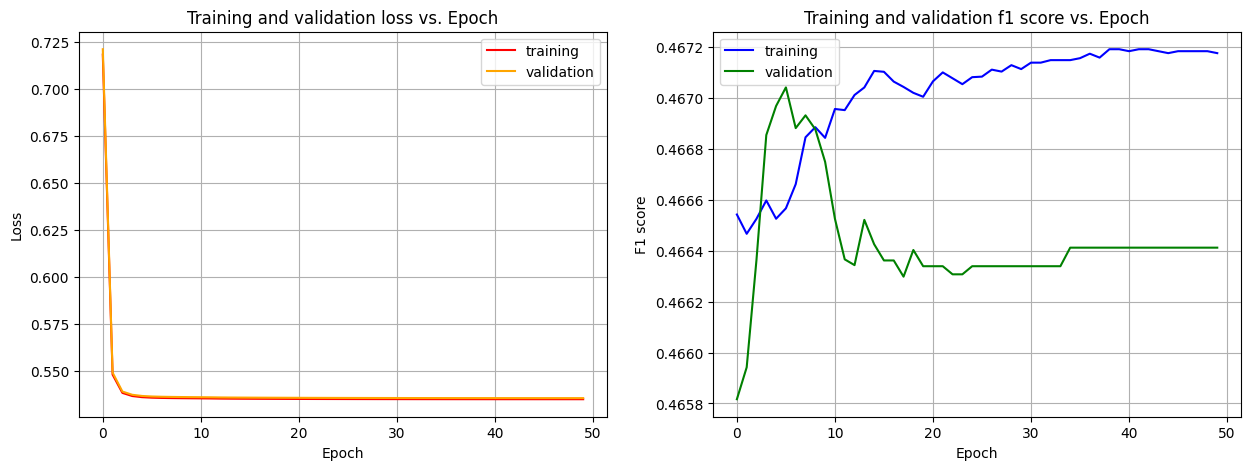

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_loss_history, color="red", label="training")
axes[0].plot(val_loss_history, color="orange", label="validation")
axes[0].set_title('Training and validation loss vs. Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid()
axes[0].legend()

axes[1].plot(train_f1_history, color="blue", label="training")
axes[1].plot(val_f1_history, color="green", label="validation")
axes[1].set_title('Training and validation f1 score vs. Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 score')
axes[1].grid()
axes[1].legend()

plt.show()

It looks like the loss cannot get lower.

### Comparing validation scores

Let's compare the models' f1 scores on the validation set to see if the stacked model performs better than the two base models:

In [ ]:
continuous_X_val, non_continuous_X_val = get_bernoulli_data(X_val)
print(
  "Bernoulli x logistic regression validation score:",
  f1_score(y_val, predict_bernoulli_logistic_regression(continuous_X_val, non_continuous_X_val, bnb_model, log_reg))
)

X_val_nn = get_neural_net_data(X_val)
print(
  "Neural network validation score:",
  f1_score(y_val, predict_neural_network(X_val_nn, neural_net))
)

X_meta_val = get_meta_model_data(X_val, bnb_model, log_reg, neural_net)
print(
  "Stacked validation score:",
  f1_score(y_val, predict_meta_model(X_meta_val, meta_model))
)

Bernoulli x logistic regression validation score: 0.43643382544733683
Neural network validation score: 0.46670764187666464
Stacked validation score: 0.4670412498286967


The stacked model seems slightly better.

# 4. Submission

We are using our stacked model to make predictions on the testing set.

In [ ]:
X_meta_test = get_meta_model_data(test_features_processed, bnb_model, log_reg, neural_net)
predictions = predict_meta_model(X_meta_test, meta_model)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
output = pd.DataFrame({
  'index': test_ids,
  'Diabetes_binary': predictions,
})
output.to_csv('submission.csv', index=False)
output

,index,Diabetes_binary
0,219620,0
1,132821,0
2,151862,0
3,139717,0
4,239235,1
...,...,...
50731,169513,0
50732,182415,0
50733,109739,0
50734,181671,0
